In [1]:
import os
import pandas as pd
import json
from collections import Counter
import seaborn as sns
from netpixi.integration.gt import *
from netpixi.integration.gt import Graph
from regression.integration.gt import *
import netpixi
from collections import defaultdict
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import cpnet
from graph_tool import spectral

import numpy as np
from collections import defaultdict
import itertools
g = Graph(directed=False)
files = os.listdir('./jsons')

json_files = [file for file in files if file.endswith('.json')]

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


Na célula a seguir pegamos todas as informações encontradas nos arquivos JSON e juntamos em um dataframe.

In [2]:
df_combined = pd.DataFrame()

for json_file in json_files:
    data = []
    with open(f"jsons/{json_file}", 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                pass
    df = pd.DataFrame(data)
    df_combined = pd.concat([df_combined, df], ignore_index=True)
print(len(df_combined))

13707


In [3]:
df_combined.columns

Index(['apiURLs', 'asins', 'brand', 'categories', 'colors', 'dateAdded',
       'dateUpdated', 'descriptions', 'dimension', 'domains', 'ean', 'ean13',
       'features', 'gtins', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'merchants', 'mostRecentPriceAmount',
       'mostRecentPriceNonSalesAmount', 'mostRecentPriceAvailability',
       'mostRecentPriceCurrency', 'mostRecentPriceColor',
       'mostRecentPriceIsSale', 'mostRecentPriceDomain',
       'mostRecentPriceSourceURL', 'mostRecentPriceDate',
       'mostRecentPriceFirstDateSeen', 'mostRecentPriceByDomain', 'name',
       'prices', 'primaryCategories', 'primaryImageURLs', 'quantities',
       'reviews', 'secondaryCategories', 'skus', 'sourceURLs', 'taxonomy',
       'taxonomyLevel1', 'taxonomyLevel2', 'taxonomyLevel3', 'taxonomyLevel4',
       'taxonomyLevel5', 'taxonomyLevel6', 'taxonomyLevel7', 'upc', 'upca',
       'websiteIDs', 'weight', 'id', 'financingAndLeasing', 'sizes',
       'mostRecentPriceCondi

Pegamos todos os usuários dentro de todos os reviews

In [4]:
usuarios = []
ratings = []
for reviews_produto in df_combined['reviews']:
    ratings_produto = []
    for review in reviews_produto:
        if 'username' in review.keys():
            usuarios.append(review['username'])
        if 'rating' in review.keys():
            ratings_produto.append(review['rating'])
    ratings.append(sum(ratings_produto)/len(ratings_produto))

In [5]:
len(ratings)

13707

In [6]:
from collections import defaultdict

product_reviewers = defaultdict(list)

for i, row in df_combined.iterrows():
    for review in row['reviews']:
        if 'username' in review.keys() and 'rating' in review.keys():
            username = review['username']
            product_name = row['name']
            product_reviewers[product_name].append(username)

new_df = pd.DataFrame(list(product_reviewers.items()), columns=['product_name', 'usernames'])

new_df

,product_name,usernames
0,"ThinkVision T23d 22.5"" LED Monitor (HDMI, DP, ...","[Gomi, Terryc, myOwnTwoCents, Justin from Mich..."
1,"ThinkVision M14t 14"" LED Mobile Monitor with T...","[RogueStudio, Vvvsss, Anonymous, Zusan, Jenni2..."
2,"ThinkCentre Tiny-In-One 24 Gen 4 23.8"" IPS LCD...","[Robert W in TX, ucvb9, ucvb9, AlanS3, Robert ..."
3,"ThinkVision T22v-20 21.5"" VoIP LED Monitor (HD...","[MDREAM, Kent A, Norm01, Anonymous, Sam W, Ric..."
4,Legion KM300 Full-size Wired RGB Gaming Keyboa...,"[BCarter · Review provided by lenovo.com, fwi..."
...,...,...
12967,Frigidaire FDB2410HIC - Dishwasher - built-in ...,"[Lupe51, nanapattiann, Bobbi, Ruthie, kkdidit2..."
12968,"FRIGIDAIRE FFCD2418UW0A 24"" Built-In Dishwashe...","[Stealmonkey, The ok dishwasher, Randa, Dishwa..."
12969,"Frigidaire Gallery 8,000 BTU Window Air Condit...","[Review provided by Overstock.com, Jon_M, 246..."
12970,"Frigidaire® Top Freezer Refrigerator, 18 Cu. Ft.","[TheHenees, Blanca63, Large and roomy, Cougdud..."


In [7]:
from collections import defaultdict

product_reviewers = defaultdict(lambda: defaultdict(list))

for i, row in df_combined.iterrows():
    for review in row['reviews']:
        if 'username' in review.keys() and 'rating' in review.keys():
            username = review['username']
            rating_medio = review['rating']
            product_name = row['name']
            product_reviewers[product_name]['usernames'].append(username)
            product_reviewers[product_name]['ratings'].append(rating_medio)

# Convert the defaultdict to a list of dictionaries
data = [{'product_name': k, 'usernames': v['usernames'], 'ratings': v['ratings']} 
        for k, v in product_reviewers.items()]

# Create a new DataFrame
new_df = pd.DataFrame(data)

In [8]:
new_df

,product_name,usernames,ratings
0,"ThinkVision T23d 22.5"" LED Monitor (HDMI, DP, ...","[Gomi, Terryc, myOwnTwoCents, Justin from Mich...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, ..."
1,"ThinkVision M14t 14"" LED Mobile Monitor with T...","[RogueStudio, Vvvsss, Anonymous, Zusan, Jenni2...","[5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
2,"ThinkCentre Tiny-In-One 24 Gen 4 23.8"" IPS LCD...","[Robert W in TX, ucvb9, ucvb9, AlanS3, Robert ...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, ..."
3,"ThinkVision T22v-20 21.5"" VoIP LED Monitor (HD...","[MDREAM, Kent A, Norm01, Anonymous, Sam W, Ric...","[5.0, 5.0, 5.0, 3.0, 4.0, 5.0, 1.0, 5.0, 5.0, ..."
4,Legion KM300 Full-size Wired RGB Gaming Keyboa...,"[BCarter · Review provided by lenovo.com, fwi...","[5.0, 3.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0, ..."
...,...,...,...
12967,Frigidaire FDB2410HIC - Dishwasher - built-in ...,"[Lupe51, nanapattiann, Bobbi, Ruthie, kkdidit2...","[5.0, 2.0, 5.0, 5.0, 1.0, 5.0, 4.0, 1.0, 5.0, ..."
12968,"FRIGIDAIRE FFCD2418UW0A 24"" Built-In Dishwashe...","[Stealmonkey, The ok dishwasher, Randa, Dishwa...","[5.0, 4.0, 3.0, 1.0, 2.0, 3.0, 2.0, 1.0, 5.0, ..."
12969,"Frigidaire Gallery 8,000 BTU Window Air Condit...","[Review provided by Overstock.com, Jon_M, 246...","[4.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, ..."
12970,"Frigidaire® Top Freezer Refrigerator, 18 Cu. Ft.","[TheHenees, Blanca63, Large and roomy, Cougdud...","[5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, ..."


In [9]:
ratings = []
for i, row in new_df.iterrows():
    ratings.append(sum(row['ratings'])/len(row['ratings']))
    

In [10]:
new_df['rating_medio'] = ratings

In [11]:
new_df

,product_name,usernames,ratings,rating_medio
0,"ThinkVision T23d 22.5"" LED Monitor (HDMI, DP, ...","[Gomi, Terryc, myOwnTwoCents, Justin from Mich...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, ...",4.786885
1,"ThinkVision M14t 14"" LED Mobile Monitor with T...","[RogueStudio, Vvvsss, Anonymous, Zusan, Jenni2...","[5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",4.581395
2,"ThinkCentre Tiny-In-One 24 Gen 4 23.8"" IPS LCD...","[Robert W in TX, ucvb9, ucvb9, AlanS3, Robert ...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, ...",4.645161
3,"ThinkVision T22v-20 21.5"" VoIP LED Monitor (HD...","[MDREAM, Kent A, Norm01, Anonymous, Sam W, Ric...","[5.0, 5.0, 5.0, 3.0, 4.0, 5.0, 1.0, 5.0, 5.0, ...",4.344262
4,Legion KM300 Full-size Wired RGB Gaming Keyboa...,"[BCarter · Review provided by lenovo.com, fwi...","[5.0, 3.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0, ...",4.736842
...,...,...,...,...
12967,Frigidaire FDB2410HIC - Dishwasher - built-in ...,"[Lupe51, nanapattiann, Bobbi, Ruthie, kkdidit2...","[5.0, 2.0, 5.0, 5.0, 1.0, 5.0, 4.0, 1.0, 5.0, ...",3.700000
12968,"FRIGIDAIRE FFCD2418UW0A 24"" Built-In Dishwashe...","[Stealmonkey, The ok dishwasher, Randa, Dishwa...","[5.0, 4.0, 3.0, 1.0, 2.0, 3.0, 2.0, 1.0, 5.0, ...",3.000000
12969,"Frigidaire Gallery 8,000 BTU Window Air Condit...","[Review provided by Overstock.com, Jon_M, 246...","[4.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, ...",4.321995
12970,"Frigidaire® Top Freezer Refrigerator, 18 Cu. Ft.","[TheHenees, Blanca63, Large and roomy, Cougdud...","[5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, ...",4.900000


Fazemos o sampling do dataframe, pois ele é muito grande e um computador comum seria incapaz de rodar todo o 
código a seguir com um dataframe tão grande

In [12]:
dicionario = {}

for i, row in new_df.iterrows():
    dicionario[row['product_name']] = row['rating_medio']

In [14]:
df_sample = new_df.sample(n=2000)
print(len(df_sample))

2000


In [15]:
df = df_sample.loc[~df_sample['usernames'].isin(['Anonymous', 'anonymous', 'ByAmazonCustomer', 'Amazon Customer'])]
print(df['usernames'])

df = df.explode('usernames')


pivot_table = df.groupby(['usernames','product_name']).size().unstack(fill_value=0)

new_df_data = []
for _, row in pivot_table.iterrows():
    reviewed_products = row[row > 0].index.tolist()
    
    for product1, product2 in combinations(reviewed_products, 2):
        new_df_data.append((f"{product1}_{product2}", 1))

new_df = pd.DataFrame(new_df_data, columns=['product_pair', 'weight'])

new_df = new_df.groupby('product_pair').sum().reset_index()

3163     [lg, jrch, Schandler, Jo91709, paula77, lg, lg...
9529     [Amazon Customer, Amy Ernst, Robert, James, Ja...
6228     [Jack, desertdora, Gary J., Derrick, wilhelm, ...
8846     [KScott, scoutenang, ohot_nik, buck4x4, Fisher...
3061     [KevMc · Review provided by  Best Buy, Bluetoo...
                               ...                        
10717    [Joe, Miranda Hansen, Al, Noah, MC, Chrissy, L...
7513     [Chase, Anonymous, Des · Review provided by  C...
8283     [jrrider, jwhmarketing · Review provided by  e...
1149     [Ally · Review provided by  Target, Reyes, Sem...
12349    [Anonymous, Greg S., Salvatore R., Alexander B...
Name: usernames, Length: 2000, dtype: object


In [16]:
new_df

,product_pair,weight
0,(Acer Certified) Acer UM.FX1AA.001 Predator XB...,1
1,(Acer Certified) Acer UM.FX1AA.001 Predator XB...,1
2,(Acer Certified) Acer UM.FX1AA.001 Predator XB...,5
3,(Acer Certified) Acer UM.FX1AA.001 Predator XB...,1
4,(Acer Certified) Acer UM.FX1AA.001 Predator XB...,2
...,...,...
444075,iPhone XS Max Silicone Case - Red_logitech G L...,1
444076,iPhone XS Max Silicone Case - Red_logitech zer...,2
444077,imageCLASS LBP6230DW Wireless Black-and-White ...,1
444078,imageCLASS MF743Cdw Wireless Color All-In-One ...,1


In [17]:
df_novo_dataset = new_df.groupby('weight').size().reset_index(name='count')

df_filtrado = df_novo_dataset.loc[df_novo_dataset['weight'] < 26]
df_filtrado

,weight,count
0,1,323498
1,2,61174
2,3,22810
3,4,11780
4,5,6913
5,6,4458
6,7,3038
7,8,2246
8,9,1587
9,10,1216


In [18]:
new_df = new_df.loc[new_df['weight'] >= 2]
new_df

,product_pair,weight
2,(Acer Certified) Acer UM.FX1AA.001 Predator XB...,5
4,(Acer Certified) Acer UM.FX1AA.001 Predator XB...,2
5,(Acer Certified) Acer UM.FX1AA.001 Predator XB...,3
7,(Acer Certified) Acer UM.FX1AA.001 Predator XB...,2
8,(Acer Certified) Acer UM.FX1AA.001 Predator XB...,2
...,...,...
444055,iPhone 11 Clear Case_iPhone 11 Silicone Case,33
444062,iPhone 11 Silicone Case_iPhone 12 Pro Max Sili...,3
444067,iPhone 12 Pro Max Silicone Case with MagSafe_i...,6
444070,iPhone XS Max Leather Case - Midnight Blue_iPh...,2


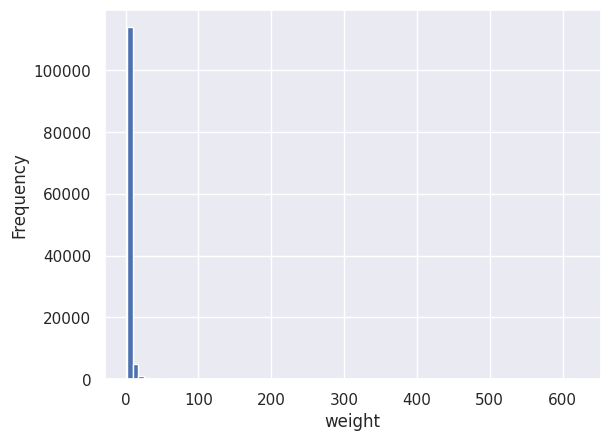

In [19]:
new_df["weight"].plot.hist(bins=80)
plt.xlabel("weight")
plt.show()

In [20]:
import csv
from collections import defaultdict
from itertools import combinations
from sklearn.preprocessing import LabelEncoder

username_counts = defaultdict(int)

for username, row in pivot_table.iterrows():
    if username in ['Anonymous', 'anonymous', 'ByAmazonCustomer', 'Amazon Customer']:
        continue

    reviewed_products = row[row > 0].index.tolist()

    username_counts[username] += len(reviewed_products)

data_dict = defaultdict(list)

for username, row in pivot_table.iterrows():

    if username_counts[username] > 200:
        continue

    reviewed_products = row[row > 0].index.tolist()

    for product1, product2 in combinations(reviewed_products, 2):
        data_dict[(product1, product2)].append(username)

new_df = pd.DataFrame(list(data_dict.items()), columns=['product_pair', 'usernames'])

new_df['weight'] = new_df['usernames'].apply(len)

new_df = new_df[new_df['weight'] >= 4]

product_encoder = LabelEncoder()

all_product_names = set([product for pair in new_df['product_pair'] for product in pair])

product_encoder.fit(list(all_product_names))

with open('edges.txt', 'w', newline='') as f:
    writer = csv.writer(f, delimiter='\t')
    for _, row in new_df.iterrows():
        product1, product2 = row['product_pair']
        encoded_product1 = product_encoder.transform([product1])[0]
        encoded_product2 = product_encoder.transform([product2])[0]
        writer.writerow([encoded_product1, encoded_product2])


<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


In [21]:
new_df

,product_pair,usernames,weight
0,"(Canon CLI-226 Black Ink Tank, Canon CLI-8 Ink...","["" · Review provided by staples.com, Anonymou...",11
1,"(Canon CLI-226 Black Ink Tank, Canon PG-240XXL...","["" · Review provided by staples.com, DAN · Re...",6
11,"(Canon CLI-8 Ink Cartridge - Yellow, Canon PG-...","["" · Review provided by staples.com, DAN · Re...",4
30,"(Epson - Black Ink - (CMYK) 4-Pack 212XL, Epso...","["" · Review provided by staples.com, ALLICIA ...",15
32,"(Epson - Black Ink - (CMYK) 4-Pack 212XL, Epso...","["" · Review provided by staples.com, ALLICIA ...",15
...,...,...,...
407603,"(Canon EF 70-300mm f/4-5.6L IS USM Lens, Dell ...","[Robin, Scott, Tom, john]",4
407665,(Arlo Wire-Free HD Security Camera Only VMC303...,"[Rodney, Scott, Stan, Steven]",4
409212,"(Samsung Q60A QN70Q60AAV 69.5"" Smart LED TV - ...",[Samsung2021Buyer · Review provided by samsun...,4
419808,"(Samsung Galaxy S9 64GB Unlocked Smartphone, B...","[ally.t · Review provided by influenster.com,...",5


In [22]:
f = open("edges.txt", "r")
x = f.readlines()

vertices = []
i = 0
while i <= len(x)-1:
    z = x[i].split('\t')
    y = z[1].strip('\n')
    if z[0] not in vertices:
        vertices.append(int(z[0]))
    if y not in vertices:
        vertices.append(int(y))
    if i%1000 == 0:
        print(i)
    i +=1
vertices = list(dict.fromkeys(vertices) )

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


In [23]:
for v in vertices:
    g.add_vertex(v)
print('número de vértices de g:', g.num_vertices())

número de vértices de g: 932


In [24]:
i = 0
while i <= len(x)-1:
    z = x[i].split('\t')
    y = int(z[1].strip('\n'))
    g.add_edge(int(z[0]), y)
    i +=1
    
print('número de arestas de g:', g.num_edges())

número de arestas de g: 27708


In [25]:
gt_save(g, 'products.net.gz')

In [26]:
g = gt_load('products.net.gz')

In [27]:
m = g.num_edges()
n = g.num_vertices()
print(f"Arestas = {m}")
print(f"Vertices = {n}")
if g.is_directed():
    max_edges = n * (n - 1)
else:
    max_edges = n * (n - 1) // 2
max_edges
d = m / max_edges
print(f"Densidade = {d}")

Arestas = 27708
Vertices = 932
Densidade = 0.06386598009431918


In [28]:
data = gt_data(g)
data

""
id
182
187
214
294
296
...
711
537
410


In [29]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())
data['degree'] = degrees
data

,degree
id,
182,31
187,2
214,25
294,2
296,10
...,...
711,2
537,1
410,2


count    932.000000
mean      59.459227
std       93.482621
min        1.000000
25%        3.000000
50%       14.000000
75%       74.250000
max      712.000000
Name: degree, dtype: float64

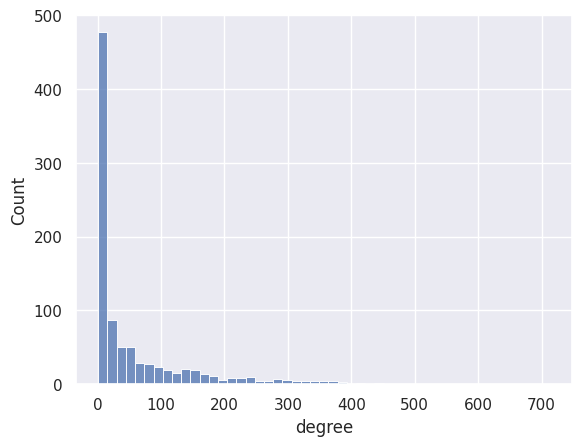

In [30]:
sns.histplot(data['degree'])
data['degree'].describe()

In [31]:
g = gt_load('products.net.gz')
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g, 'exemplo.net.gz')
netpixi.render('exemplo.net.gz');

In [32]:
g = gt_clean(g)
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g, 'exemplo.net.gz')
r = netpixi.render('exemplo.net.gz', infinite=True);

In [33]:
matrix = spectral.adjacency(g)
algorithm = cpnet.Rombach()
algorithm.detect(matrix)
c = algorithm.get_coreness()

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()


In [34]:
g.add_vp('coreness')
for i, coreness in c.items():
    v = g.get_vertex_by_index(i)
    v['coreness'] = float(coreness)

for v in g.all_vertices():
    r.vertex(v['id'], size=(10 + 40 * v['coreness']))

In [35]:
df_single_product = new_df.explode('product_pair')


In [36]:
df_final = df_single_product.groupby('product_pair')['usernames'].count().reset_index()
df_final.columns = ['product', 'usernames_count']

In [37]:
df_final['coreness'] = df_final.index.map(c.get)

In [38]:
df_final = df_final.dropna()
df_final

,product,usernames_count,coreness
0,(Acer Certified) Acer UM.FX1AA.001 Predator XB...,22,0.207020
1,- Intel 540s Series 240GB M.2 SATA 6GB/s Solid...,2,0.035100
2,- Seagate 1TB 5400RPM SATA 6Gb/s 128MB Cache 2...,195,0.188037
3,1.2 cu. ft. Countertop Convection Microwave wi...,16,0.011461
4,1.4 cu. ft. Countertop Microwave with Sensor Cook,109,0.125000
...,...,...,...
868,Sony UHS-II Memory Card (64GB),156,0.010745
869,Sony VPL-HW45ES Full HD SXRD Home Cinema Proje...,1,0.082378
870,Sony WF-XB700 Truly Wireless Bluetooth Headpho...,101,0.143266
871,Sony WI-SP500 Wireless In-Ear Sports Headphone...,2,0.068768


In [41]:
rating_medio_produto = []
for i, row in df_final.iterrows():
    rating_medio_produto.append(dicionario[row['product']])

In [44]:
df_final['rating_medio'] = rating_medio_produto

In [45]:
df_final

,product,usernames_count,coreness,rating_medio
0,(Acer Certified) Acer UM.FX1AA.001 Predator XB...,22,0.207020,4.028169
1,- Intel 540s Series 240GB M.2 SATA 6GB/s Solid...,2,0.035100,4.550000
2,- Seagate 1TB 5400RPM SATA 6Gb/s 128MB Cache 2...,195,0.188037,4.585586
3,1.2 cu. ft. Countertop Convection Microwave wi...,16,0.011461,3.899160
4,1.4 cu. ft. Countertop Microwave with Sensor Cook,109,0.125000,4.110759
...,...,...,...,...
868,Sony UHS-II Memory Card (64GB),156,0.010745,4.510417
869,Sony VPL-HW45ES Full HD SXRD Home Cinema Proje...,1,0.082378,4.600000
870,Sony WF-XB700 Truly Wireless Bluetooth Headpho...,101,0.143266,4.140351
871,Sony WI-SP500 Wireless In-Ear Sports Headphone...,2,0.068768,2.941176


In [46]:
# ratings = []
# for i, row in new_df.iterrows():
#     ratings.append(sum(row['ratings'])/len(row['ratings']))

In [47]:
df_final.dtypes

product             object
usernames_count      int64
coreness           float64
rating_medio       float64
dtype: object

In [48]:
import regression as reg
result = reg.linear(data=df_final, formula='coreness ~ usernames_count')
result.micro_summary()   

variable,coefficient,std error,p-value
usernames_count,0.000020,0.000110,0.858082


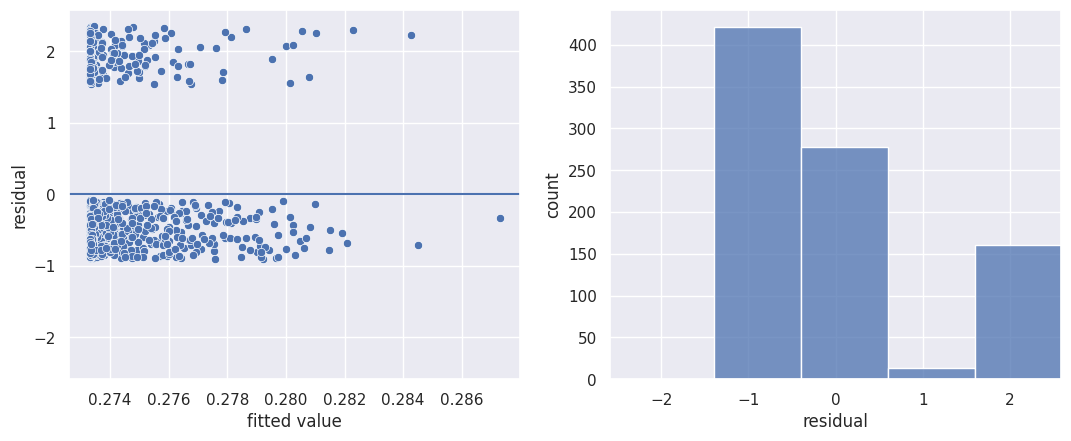

In [50]:
result.plot_residuals()

In [51]:
df_final.sort_values(by = 'coreness',
                      axis=0,
                      ascending=True,
                      inplace=False,
                      kind='quicksort',
                      na_position='last')

,product,usernames_count,coreness,rating_medio
369,Google S3006WBUS Nest Protect,219,0.000000,4.902763
6,1.8 Cu. Ft. Over-the-Range Microwave with Sens...,7,0.000358,4.092715
64,"Acer EI342CKR Pbmiippx 34"" 21:9 FreeSync Curve...",2,0.000716,3.722222
282,E PZ 18-105mm f/4.0 G OSS Power Zoom Lens for ...,55,0.001074,4.636364
754,"Samsung 12.4"" Galaxy Tab S7 FE 256GB Tablet (W...",1,0.001433,4.515152
...,...,...,...,...
132,Apple iPad Pro 11 (2nd Generation) - Wi-Fi + C...,130,0.992857,4.703297
283,EF 100-400mm f/4.5-5.6L IS II USM Telephoto Zo...,273,0.994286,4.943750
19,27” Odyssey Gaming CRG5 Series LED Curved 240H...,77,0.995714,3.743802
141,"Apple iPhone 6s 16GB, Gold - Unlocked GSM Refu...",1,0.997143,3.783784


In [52]:
df_final

,product,usernames_count,coreness,rating_medio
0,(Acer Certified) Acer UM.FX1AA.001 Predator XB...,22,0.207020,4.028169
1,- Intel 540s Series 240GB M.2 SATA 6GB/s Solid...,2,0.035100,4.550000
2,- Seagate 1TB 5400RPM SATA 6Gb/s 128MB Cache 2...,195,0.188037,4.585586
3,1.2 cu. ft. Countertop Convection Microwave wi...,16,0.011461,3.899160
4,1.4 cu. ft. Countertop Microwave with Sensor Cook,109,0.125000,4.110759
...,...,...,...,...
868,Sony UHS-II Memory Card (64GB),156,0.010745,4.510417
869,Sony VPL-HW45ES Full HD SXRD Home Cinema Proje...,1,0.082378,4.600000
870,Sony WF-XB700 Truly Wireless Bluetooth Headpho...,101,0.143266,4.140351
871,Sony WI-SP500 Wireless In-Ear Sports Headphone...,2,0.068768,2.941176


In [82]:
recorte1 = df_final.copy()
recorte2 = df_final.copy()

In [83]:
recorte1 = recorte1.loc[recorte1['rating_medio'] > 4]

In [84]:
recorte1

,product,usernames_count,coreness,rating_medio
0,(Acer Certified) Acer UM.FX1AA.001 Predator XB...,22,0.207020,4.028169
1,- Intel 540s Series 240GB M.2 SATA 6GB/s Solid...,2,0.035100,4.550000
2,- Seagate 1TB 5400RPM SATA 6Gb/s 128MB Cache 2...,195,0.188037,4.585586
4,1.4 cu. ft. Countertop Microwave with Sensor Cook,109,0.125000,4.110759
6,1.8 Cu. Ft. Over-the-Range Microwave with Sens...,7,0.000358,4.092715
...,...,...,...,...
865,Sony Professional XQD G Series 64GB Memory Car...,418,0.126791,4.757009
867,Sony SRS-XB01 - Speaker - for portable use - w...,83,0.006447,4.043011
868,Sony UHS-II Memory Card (64GB),156,0.010745,4.510417
869,Sony VPL-HW45ES Full HD SXRD Home Cinema Proje...,1,0.082378,4.600000


In [85]:
result_recorte1 = reg.linear(data=recorte1, formula='coreness ~ usernames_count')
result_recorte1.micro_summary() 

variable,coefficient,std error,p-value
usernames_count,0.000086,0.000122,0.482048


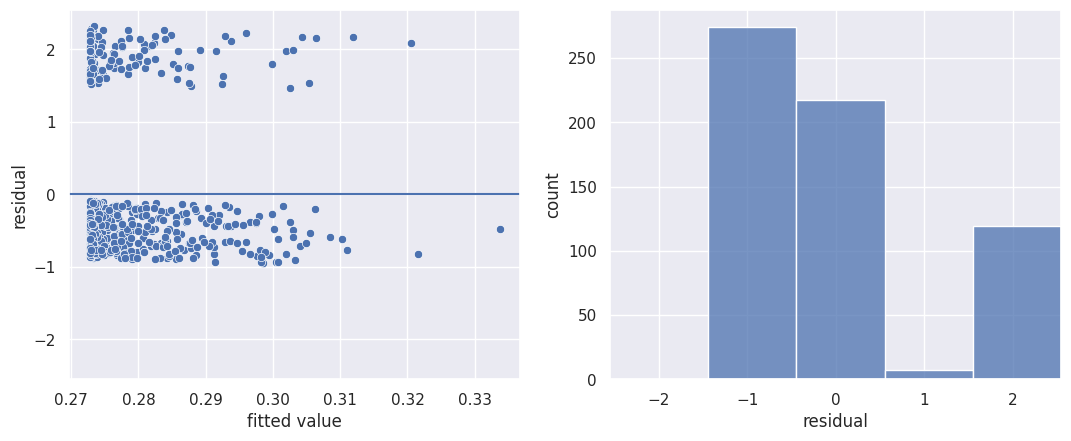

In [86]:
result_recorte1.plot_residuals()

In [87]:
recorte2 = recorte2.loc[recorte2['rating_medio'] <= 4]

In [88]:
recorte2

,product,usernames_count,coreness,rating_medio
3,1.2 cu. ft. Countertop Convection Microwave wi...,16,0.011461,3.899160
5,1.6 cu. ft. Over-the-Range Fingerprint Resist...,287,0.094198,3.899160
9,"14"" Laptop - AMD 3020e - 4GB Memory - 64 GB e...",1,0.761429,3.325581
11,15.6 144HZ FHD I7-9750H RTX 2060 GDDR6 6GB 8GB...,1,0.140401,3.588235
12,"17.3"" FHD Gaming Laptop - Intel Core i7 - 16GB...",6,0.083811,3.466667
...,...,...,...,...
859,Sony MDR-EX15AP EX Monitor Headphones (Blue),74,0.092407,3.724771
862,Sony MDREX15LP In-Ear Earbud Headphones,5,0.080229,3.640625
866,Sony SRS-XB01 - Speaker - for portable use - w...,29,0.041905,3.815789
871,Sony WI-SP500 Wireless In-Ear Sports Headphone...,2,0.068768,2.941176


In [89]:
result_recorte2 = reg.linear(data=recorte2, formula='coreness ~ usernames_count')
result_recorte2.micro_summary()

variable,coefficient,std error,p-value
usernames_count,-0.000489,0.000291,0.094137


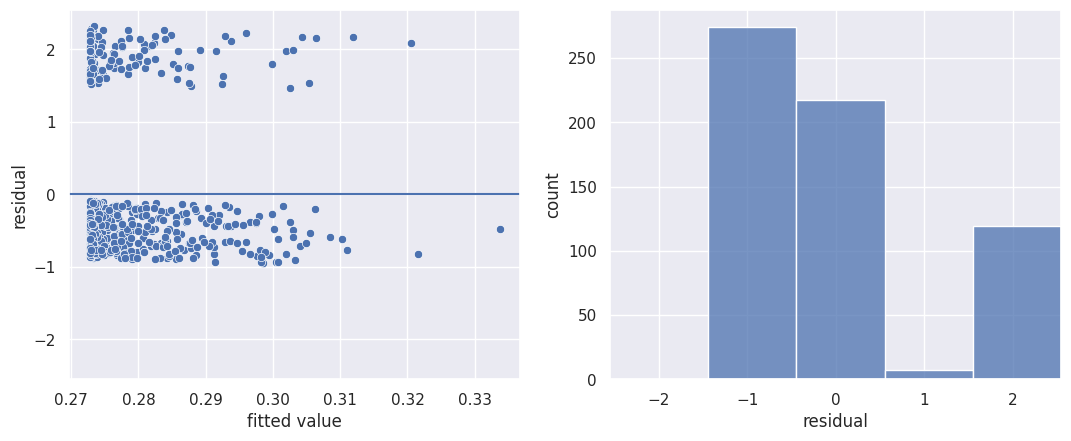

In [90]:
result_recorte1.plot_residuals()